# Import

In [1]:
!pip install pmdarima


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 33.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from pmdarima import auto_arima

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, LSTM, Dropout, Activation
from sklearn.metrics import mean_squared_error
import math
from tensorflow.keras.metrics import RootMeanSquaredError

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from scipy.special import inv_boxcox
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# EDA

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Accidents0514.csv')

<ipython-input-4-deecea512e7c>:1: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Accidents0514.csv')


In [5]:
df.head()

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
0,200501BS00001,525680.0,178240.0,-0.191170,51.489096,1,2,1,1,04/01/2005,...,0,1,1,2,2,0,0,1,1,E01002849
1,200501BS00002,524170.0,181650.0,-0.211708,51.520075,1,3,1,1,05/01/2005,...,0,5,4,1,1,0,0,1,1,E01002909
2,200501BS00003,524520.0,182240.0,-0.206458,51.525301,1,3,2,1,06/01/2005,...,0,0,4,1,1,0,0,1,1,E01002857
3,200501BS00004,526900.0,177530.0,-0.173862,51.482442,1,3,1,1,07/01/2005,...,0,0,1,1,1,0,0,1,1,E01002840
4,200501BS00005,528060.0,179040.0,-0.156618,51.495752,1,3,1,1,10/01/2005,...,0,0,7,1,2,0,0,1,1,E01002863


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1640597 entries, 0 to 1640596
Data columns (total 32 columns):
 #   Column                                       Non-Null Count    Dtype  
---  ------                                       --------------    -----  
 0   Accident_Index                               1640597 non-null  object 
 1   Location_Easting_OSGR                        1640486 non-null  float64
 2   Location_Northing_OSGR                       1640486 non-null  float64
 3   Longitude                                    1640486 non-null  float64
 4   Latitude                                     1640486 non-null  float64
 5   Police_Force                                 1640597 non-null  int64  
 6   Accident_Severity                            1640597 non-null  int64  
 7   Number_of_Vehicles                           1640597 non-null  int64  
 8   Number_of_Casualties                         1640597 non-null  int64  
 9   Date                                         1

In [6]:
df = df[['Accident_Index','Date']]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1640597 entries, 0 to 1640596
Data columns (total 2 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   Accident_Index  1640597 non-null  object
 1   Date            1640597 non-null  object
dtypes: object(2)
memory usage: 25.0+ MB


In [ ]:
df.head()

,Accident_Index,Date
0,200501BS00001,04/01/2005
1,200501BS00002,05/01/2005
2,200501BS00003,06/01/2005
3,200501BS00004,07/01/2005
4,200501BS00005,10/01/2005


In [8]:
df['Date'] = pd.to_datetime(df['Date'],format='%d/%m/%Y')
df['Date'] = df['Date'].dt.date

In [9]:
def aggregate_daily_accidents(df):
    # Ensure the date column is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])

    # Set the date column as the index
    df.set_index('Date', inplace=True)

    # Resample by day and count the number of accidents
    daily_accidents = df.resample('D').count()

    # Rename the Accident_Index column to Accident_Count
    daily_accidents.rename(columns={'Accident_Index': 'Accident_Count'}, inplace=True)

    # Create a date range from the start of the data to the end of 2014
    full_date_range = pd.date_range(start=daily_accidents.index.min(), end='2014-12-31', freq='D')

    # Reindex the DataFrame to include all days in the full date range
    daily_accidents = daily_accidents.reindex(full_date_range, fill_value=0)

    # Reset the index to get the date column back
    daily_accidents.reset_index(inplace=True)

    # Rename the index column to 'date'
    daily_accidents.rename(columns={'index': 'Date'}, inplace=True)

    return daily_accidents

In [10]:
# Function For Ploting Prediction The Models
def plot_predictions(true_values, predictions, title="Predictions vs True Values"):
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaler.fit(y_train.reshape(-1, 1))
  predictions_rescaled = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], 4))), axis=1))[:, 0]
  y_test_rescaled = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 4))), axis=1))[:, 0]
  plt.figure(figsize=(10, 6))
  plt.plot(true_values, label='True Values', color='blue', marker='o')
  plt.plot(predictions, label='Predicted Values', color='red', marker='x')
  plt.title(title)
  plt.xlabel('Index')
  plt.ylabel('Values')
  plt.legend()
  plt.show()



In [11]:
# Function For Evaluating The Models
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [12]:
df = aggregate_daily_accidents(df)

In [13]:
df.head()

,Date,Accident_Count
0,2005-01-01,308
1,2005-01-02,306
2,2005-01-03,293
3,2005-01-04,473
4,2005-01-05,523


In [14]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [15]:
df.head()

,Accident_Count
Date,
2005-01-01,308
2005-01-02,306
2005-01-03,293
2005-01-04,473
2005-01-05,523


In [16]:
df.sample(10)

,Accident_Count
Date,
2014-01-01,267
2009-03-25,439
2009-12-07,551
2005-05-14,585
2013-02-11,310
2005-02-08,584
2013-10-01,418
2010-06-25,527
2008-01-23,443


In [17]:
contains_zeros = (df['Accident_Count'] == 0).any()

if contains_zeros:
    print("Contains zero values")
else:
    print("Does not contain zero values")

Does not contain zero values


In [18]:
df.shape

(3652, 1)

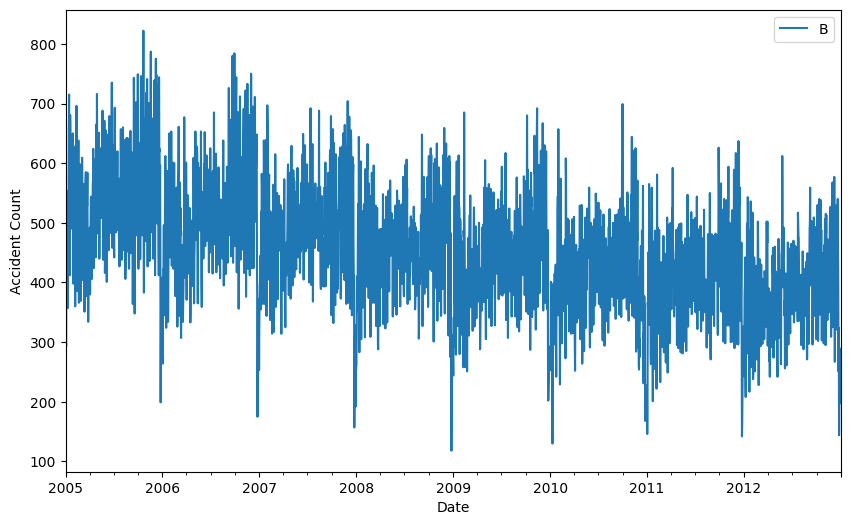

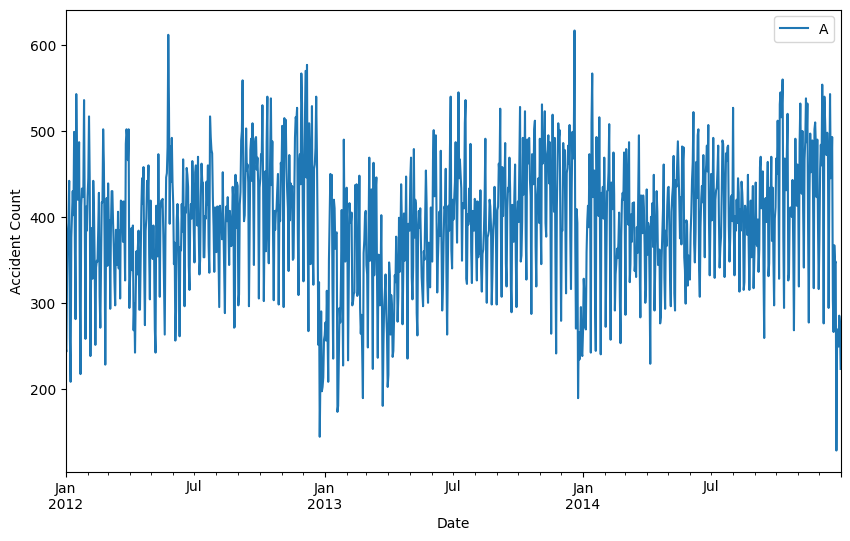

In [ ]:
df[:'2012'].plot(figsize=(10,6),legend=True)
plt.legend('Before 2012:')
plt.ylabel('Accident Count')
df['2012':].plot(figsize=(10,6),legend=True)
plt.legend('After 2012:')
plt.ylabel('Accident Count')
plt.show()

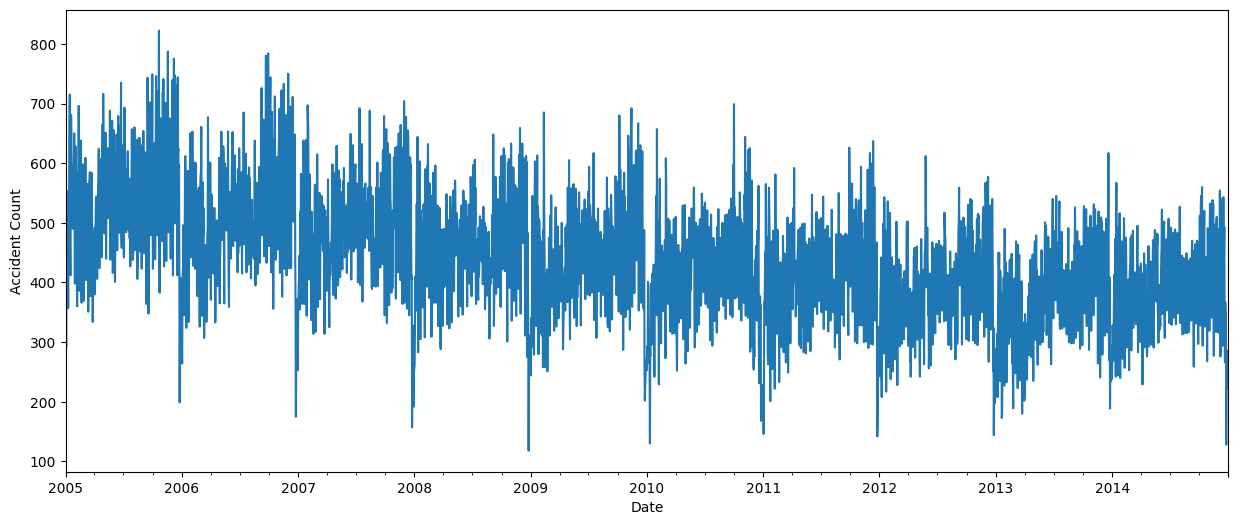

In [ ]:
df['Accident_Count'].plot(figsize=(15,6))
plt.ylabel('Accident Count')
plt.show()

# Train and Scale

In [19]:
training_set = df[:'2012']
test_set = df['2012':]

In [20]:
training_set.shape

(2922, 1)

In [ ]:
test_set.shape

(1096, 1)

In [21]:
sc = MinMaxScaler(feature_range=(0,1))
train_set_scaled = sc.fit_transform(training_set)
test_set_scaled = sc.transform(test_set)

In [22]:
# Prepare the data for LSTM and other models
def create_dataset(dataset, time_step):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0:dataset.shape[1]]
        X.append(a)
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

In [23]:
X_train, y_train = create_dataset(train_set_scaled, 10)
X_test, y_test = create_dataset(test_set_scaled, 10)

In [24]:
print('X_train.shape',X_train.shape)
print('y_train.shape',y_train.shape)
print('X_test.shape',X_test.shape)
print('y_test.shape',y_test.shape)

X_train.shape (2911, 10, 1)
y_train.shape (2911,)
X_test.shape (1085, 10, 1)
y_test.shape (1085,)


# GRU MODEL

In [25]:
#Bulid The GRU Model
model2 = Sequential()
#First GRU layer with Dropout regularisation
model2.add(GRU(200, return_sequences=True, input_shape=(10, 1),activation='relu'))
#Second GRU layer
model2.add(GRU(64))
#Out Put Layer
model2.add(Dense(1))

model2.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
#Summary Of the model
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 10, 200)             │         121,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          51,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 172,937 (675.54 KB)

 Trainable params: 172,937 (675.54 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
#Train The GRU Model
model2_fit =model2.fit(X_train, y_train, epochs=25, batch_size=32,validation_data=(X_test, y_test))

Epoch 1/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.0484 - val_loss: 0.0122
Epoch 2/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0135 - val_loss: 0.0100
Epoch 3/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0140 - val_loss: 0.0116
Epoch 4/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.0135 - val_loss: 0.0096
Epoch 5/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0124 - val_loss: 0.0095
Epoch 6/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0113 - val_loss: 0.0085
Epoch 7/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0114 - val_loss: 0.0084
Epoch 8/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0112 - val_loss: 0.0084
Epoch 9/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0108 - val_loss: 0.0074
Epoch 10/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0091 - val_loss: 0.0071
Epoch 11/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0092 - val_loss: 0.0059
Epoch 12/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0

In [28]:
#production Of The GRU Model
predict2 = model2.predict(X_test)

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


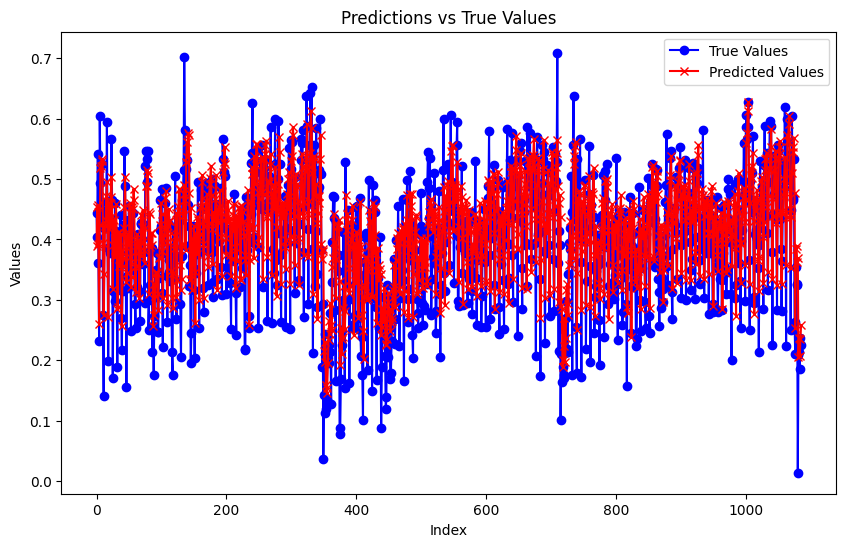

In [29]:
plot_predictions(y_test,predict2)

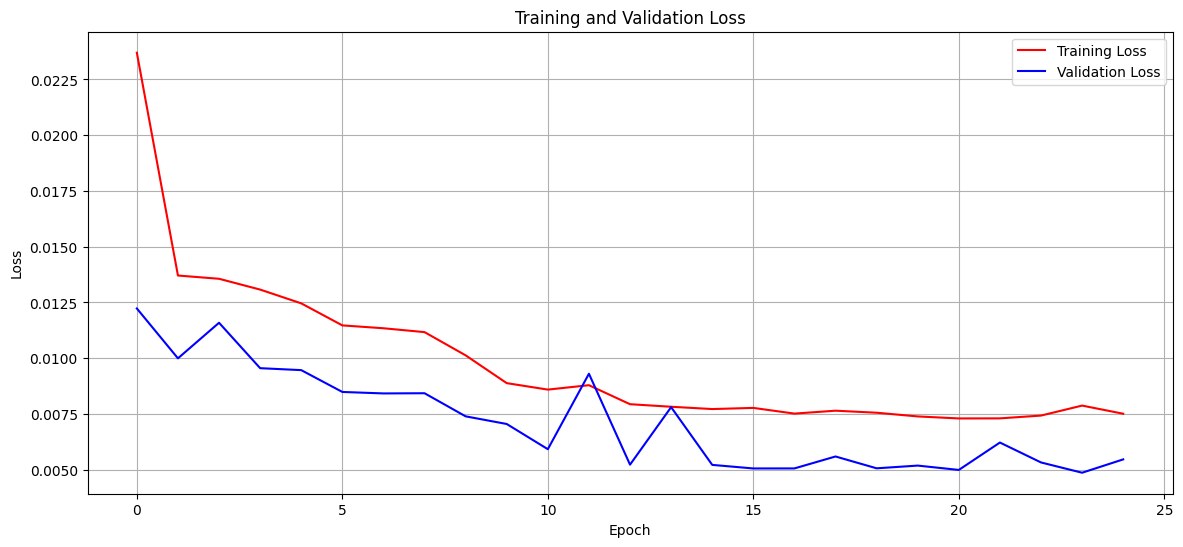

In [30]:
plt.figure(figsize=(14, 6))
plt.plot(model2_fit.history['loss'], label='Training Loss', color='red')
plt.plot(model2_fit.history['val_loss'], label='Validation Loss', color='blue')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
# Model GRU Evaluate
return_rmse(y_test,predict2)

The root mean squared error is 0.07391440665084316.


In [32]:
model2.evaluate(X_test,y_test)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0056


0.005463339388370514

# LSTM Model

In [ ]:
#Bulid The Model LSTM
model1 = Sequential()
model1.add(LSTM(128, return_sequences=True, input_shape=(10, 1)))
model1.add(LSTM(64))
model1.add(Dense(1))

model1.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10, 128)           66560     
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 116033 (453.25 KB)
Trainable params: 116033 (453.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the model LSTM
model1_fit = model1.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/100
46/46 [==============================] - 5s 41ms/step - loss: 0.0392 - val_loss: 0.0099
Epoch 2/100
46/46 [==============================] - 1s 24ms/step - loss: 0.0138 - val_loss: 0.0105
Epoch 3/100
46/46 [==============================] - 1s 23ms/step - loss: 0.0136 - val_loss: 0.0106
Epoch 4/100
46/46 [==============================] - 1s 23ms/step - loss: 0.0136 - val_loss: 0.0104
Epoch 5/100
46/46 [==============================] - 1s 23ms/step - loss: 0.0135 - val_loss: 0.0113
Epoch 6/100
46/46 [==============================] - 1s 23ms/step - loss: 0.0136 - val_loss: 0.0105
Epoch 7/100
46/46 [==============================] - 1s 23ms/step - loss: 0.0135 - val_loss: 0.0103
Epoch 8/100
46/46 [==============================] - 1s 23ms/step - loss: 0.0137 - val_loss: 0.0112
Epoch 9/100
46/46 [==============================] - 1s 23ms/step - loss: 0.0134 - val_loss: 0.0104
Epoch 10/100
46/46 [==============================] - 1s 25ms/step - loss: 0.0135 - val_loss: 0.0118

In [ ]:
#prediction For The LSTM
Predict1 = model1.predict(X_test)

34/34 [==============================] - 1s 6ms/step


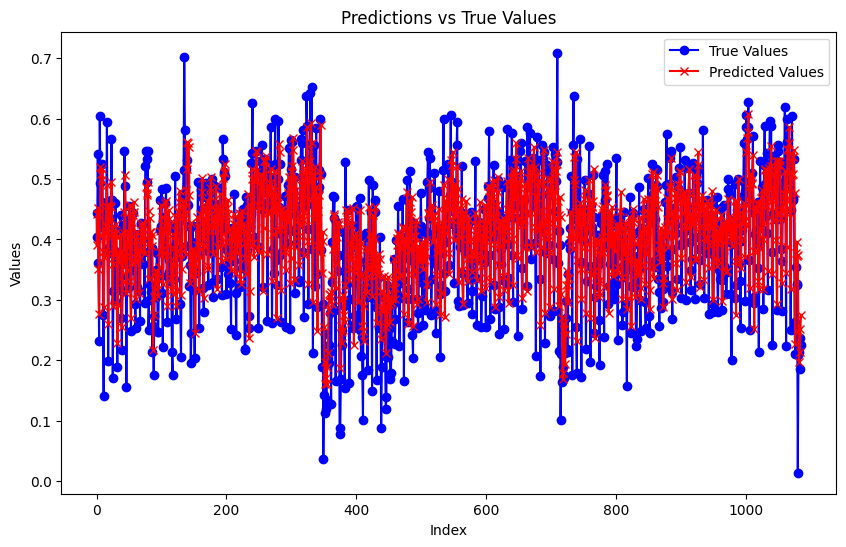

In [ ]:
#Visualizing the Results
plot_predictions(y_test,Predict1)

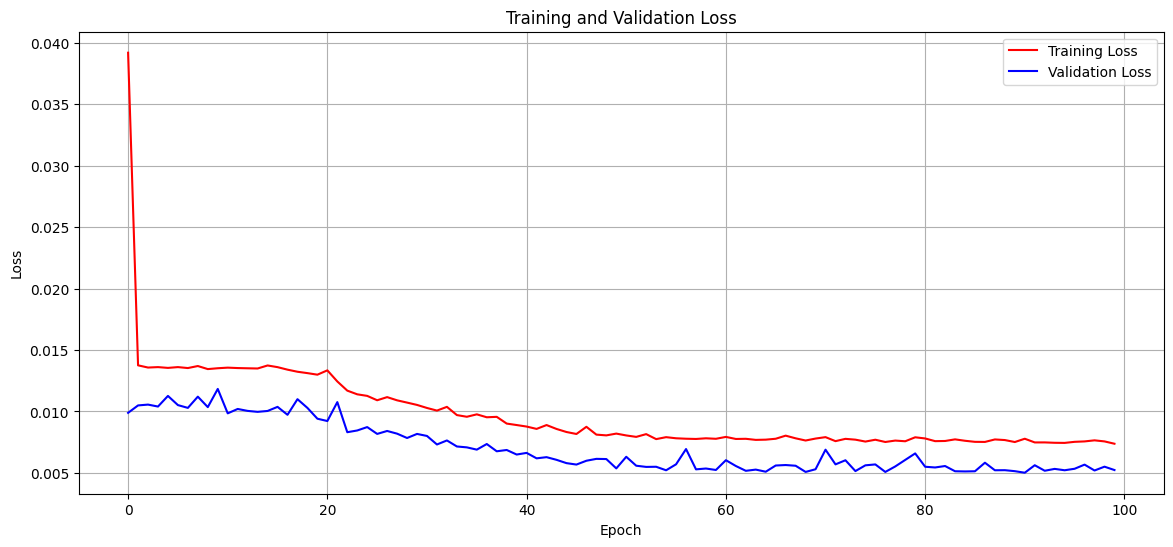

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(model1_fit.history['loss'], label='Training Loss', color='red')
plt.plot(model1_fit.history['val_loss'], label='Validation Loss', color='blue')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
## Model LSTM Evaluate
return_rmse(y_test,Predict1)

The root mean squared error is 0.07235244266607167.


In [ ]:
model1.evaluate(X_test,y_test)

34/34 [==============================] - 0s 6ms/step - loss: 0.0052


0.005234876181930304

# ARIMA MODEL

In [ ]:
aa = auto_arima(df['Accident_Count'],\
                        start_p =  1,  start_q = 1,
                        max_p   =  3,  max_q   = 3,
                        m       = 12, start_P  = 0,
                        d = None       , D = 1,
                        seasonal = True,
                        trace = True,
                        error_action ='ignore',   # we don't want to know if an order does not work
                        suppress_warnings = True,  # we don't want convergence warnings
                        stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=4.35 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=45351.329, Time=0.17 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=43469.046, Time=3.16 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=3.28 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=45349.406, Time=0.13 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=44914.411, Time=0.45 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=42901.346, Time=8.12 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=13.15 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=4.36 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=43616.794, Time=6.79 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=42898.715, Time=9.65 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=43372.208, Time=4.22 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=13.43 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=7.84 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : 

In [ ]:
model_arima = SARIMAX(training_set['Accident_Count'],
                order = (3,0,2),
                seasonal_order =(2, 1, 0, 12))

result = model_arima.fit()
result.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimiz

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                      Accident_Count   No. Observations:                 2922
Model:             SARIMAX(3, 0, 2)x(2, 1, [], 12)   Log Likelihood              -16979.095
Date:                             Sun, 25 Aug 2024   AIC                          33974.189
Time:                                     23:57:16   BIC                          34021.997
Sample:                                 01-01-2005   HQIC                         33991.412
                                      - 12-31-2012                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0948      0.024      3.894      0.000       0.047       0.143
ar.L2         -0.7565      0.011    -66.295      0.000      -0.779      -0.734
ar.L3          0.5325      0.025     21.722      0.000       0.484       0.581
ma.L1          0.3850      0.006     61.506      0.000       0.373       0.397
ma.L2          0.9730      0.006    153.137      0.000       0.961       0.985
ar.S.L12      -0.5386      0.028    -19.512      0.000      -0.593      -0.485
ar.S.L24      -0.4966      0.027    -18.467      0.000      -0.549      -0.444
sigma2      1.031e+04    374.205     27.561      0.000    9579.865     1.1e+04
===================================================================================
Ljung-Box (L1) (Q):                  10.37   Jarque-Bera (JB):                61.56
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
start = len(training_set)
end = len(training_set) + len(test_set) - 1

# Predictions for one-year against the test set
predictions = result.predict(start, end,  typ = 'levels')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: xlabel='Date'>

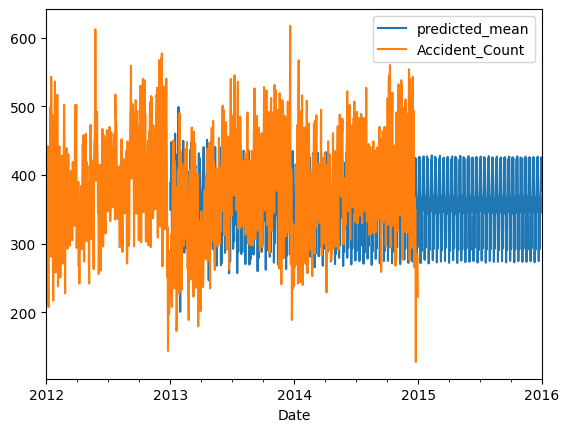

In [ ]:
predictions.plot(legend = True)
test_set['Accident_Count'].plot(legend = True)

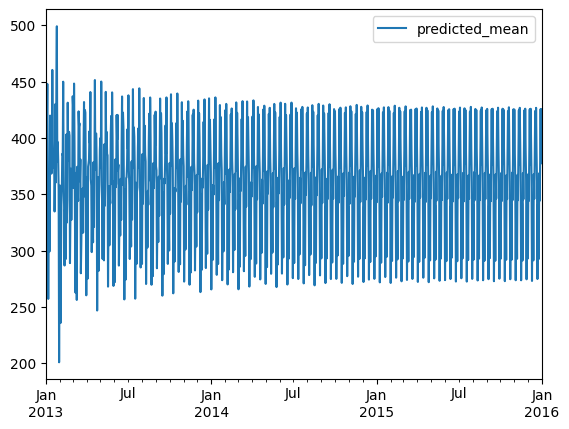

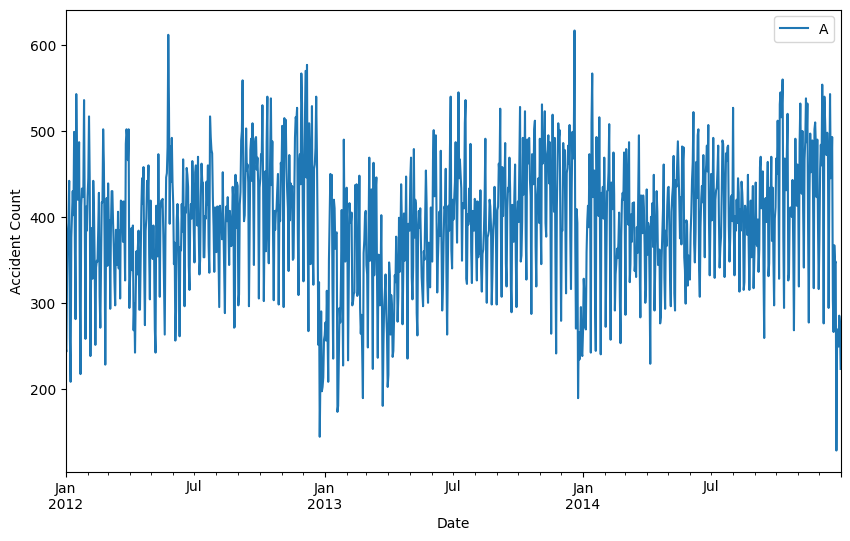

In [ ]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Calculate root mean squared error
rmse(test_set["Accident_Count"], predictions)

# Calculate mean squared error
mean_squared_error(test_set["Accident_Count"], predictions)

8924.300029363641